In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jena-climate/jena_climate_2009_2016.csv
/kaggle/input/cso-211/CDC.csv
/kaggle/input/cso-211/AQI_ex.csv
/kaggle/input/cso-211/seoul_ex.csv


In [22]:
# Loss function with improved accuracy - Seoul Dataset

# After removing date from input
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [23]:
# Function to load and preprocess the data, including date extraction
def load_and_preprocess_data_with_dates(file_path, sequence_length=60):
    # Load data and separate Date column
    data = pd.read_csv(file_path)
    dates = data['Date Time'].values  # Extract Date column
    data = data.iloc[:105000, 1:]  # Drop the Date column for scaling
    
    # Convert non-numeric columns and scale features
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.dropna()
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    X, y, sequence_dates = [], [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y.append(data_scaled[i])
        sequence_dates.append(dates[i])  # Track dates for each sequence end

    return np.array(X), np.array(y), sequence_dates, scaler

# Load and preprocess the data
file_path = '/kaggle/input/jena-climate/jena_climate_2009_2016.csv'  # Adjust path as needed
sequence_length = 60
X_jena, y_jena, sequence_dates, scaler_jena = load_and_preprocess_data_with_dates(file_path, sequence_length)


In [24]:
# Define LSTM model
def create_model(input_shape, output_dim):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(output_dim))  # Ensure output shape matches y dimension
    return model

input_shape = (X_jena.shape[1], X_jena.shape[2])
output_dim = y_jena.shape[1]
model = create_model(input_shape, output_dim)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Define Custom Loss Function with Dynamic Smoothness
class CustomLossV3(tf.keras.losses.Loss):
    def __init__(self, initial_smoothness_weight=0.01, alpha=0.5):
        super().__init__()
        self.smoothness_weight = initial_smoothness_weight
        self.alpha = alpha  # Weight for combining MAE and MSE

    def call(self, y_true, y_pred):
        mae = tf.reduce_mean(tf.abs(y_true - y_pred))
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        combined_error = self.alpha * mae + (1 - self.alpha) * mse

        smoothness_penalty = 0
        if y_pred.shape[1] > 2:
            moving_avg_diff = tf.reduce_mean(
                tf.square(y_pred[:, 2:] - (y_pred[:, 1:-1] + y_pred[:, :-2]) / 2)
            )
            smoothness_penalty = moving_avg_diff

        adaptive_weight = self.smoothness_weight * tf.exp(-0.001 * self.smoothness_weight)
        total_loss = combined_error + adaptive_weight * smoothness_penalty

        self.smoothness_weight += 0.005
        return total_loss

custom_loss = CustomLossV3()

In [26]:
# Train and plot results with custom loss function
def train_and_evaluate_with_plot(model, X, y, loss_function, loss_name, sequence_dates, scaler, epochs=10, batch_size=32):
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print(f"The accuracy using {loss_name} - MAE: {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot training loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'{loss_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Rescale predicted and true values
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_true_rescaled = scaler.inverse_transform(y)
    
    # Select only the first 5000 values
    sequence_dates_5000 = sequence_dates[:5000]
    y_pred_rescaled_5000 = y_pred_rescaled[:5000, -1]
    y_true_rescaled_5000 = y_true_rescaled[:5000, -1]
    
    # Plot Predicted vs True AQI for the first 5000 values
    plt.figure(figsize=(14, 7))
    plt.plot(sequence_dates_5000, y_true_rescaled_5000, label='True Climate', color='blue')
    plt.plot(sequence_dates_5000, y_pred_rescaled_5000, label='Predicted Climate', color='red', linestyle='dashed')
    plt.title(f'True vs Predicted AQI (First 5000 Values) with {loss_name}')
    plt.xlabel('Date')
    plt.ylabel('Climate')
    plt.legend()
    plt.show()
    
    return [mae,mse,rmse,r2]

Training with Custom Loss...
Epoch 1/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0085 - mae: 0.0114
Epoch 2/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0085 - mae: 0.0114
Epoch 3/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0085 - mae: 0.0114
Epoch 4/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0085 - mae: 0.0114
Epoch 5/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0084 - mae: 0.0114
Epoch 6/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0084 - mae: 0.0114
Epoch 7/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0084 - mae: 0.0113
Epoch 8/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0084 - mae: 0.0113
Epoch 9/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0084 - mae: 0.0113
Epoch 10/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0084 - mae: 0.0113
Epoch 11/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0084 - mae: 0.0113
Epoch 12/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26

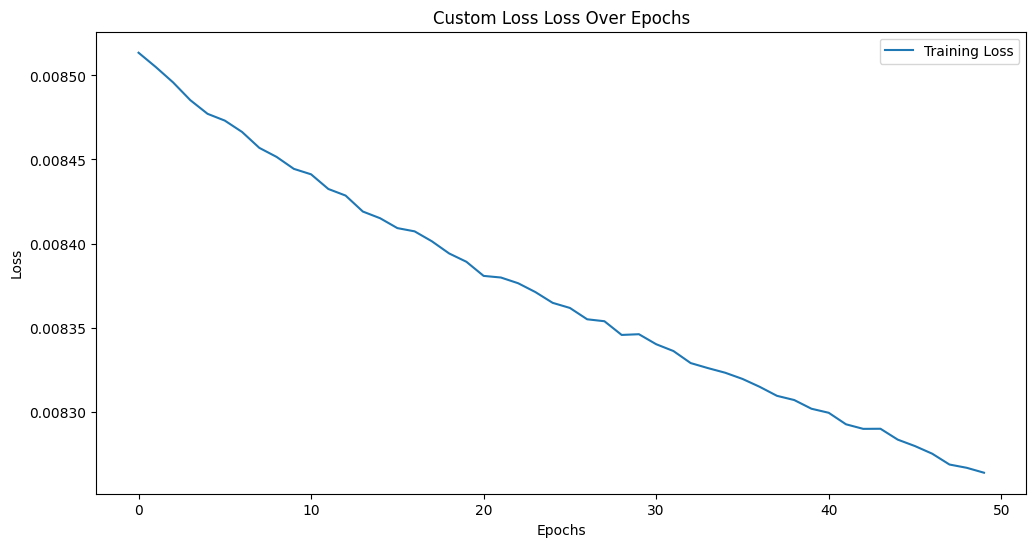

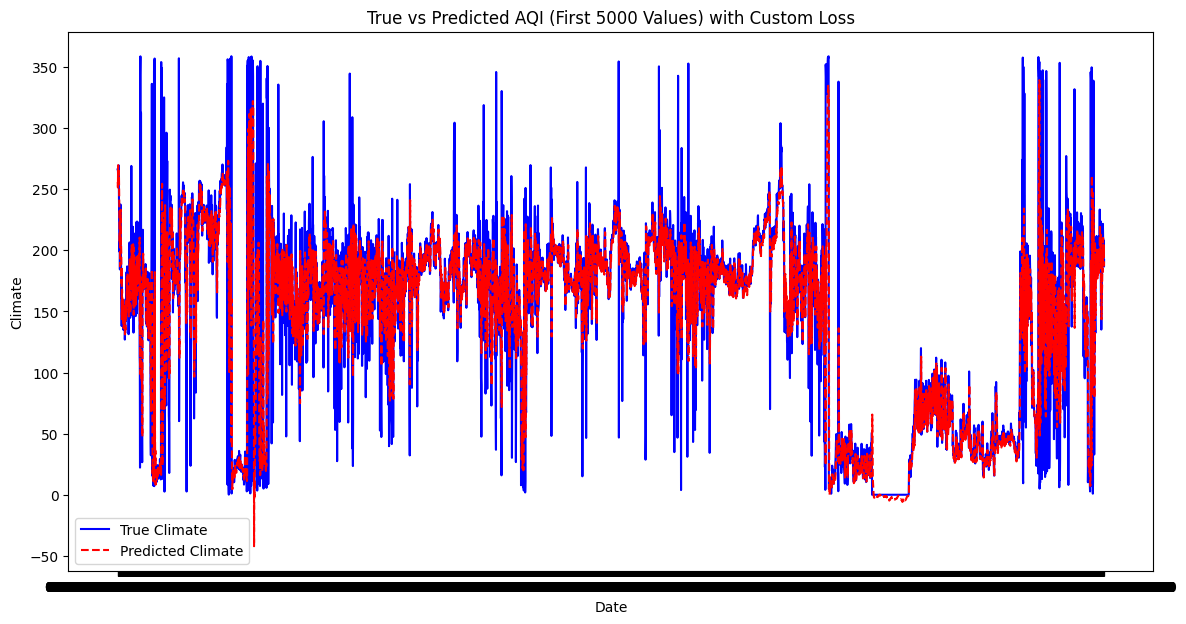

In [28]:
# Train and plot with Custom Loss
print("Training with Custom Loss...")
[mae_custom,mse_custom,rmse_custom,r2_custom] = train_and_evaluate_with_plot(model, X_jena, y_jena, custom_loss, "Custom Loss", sequence_dates, scaler_jena, epochs=50)
model.save("model_custom_loss.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with Mean Squared Error Loss...
Epoch 1/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0076 - mae: 0.0396
Epoch 2/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0020 - mae: 0.0165
Epoch 3/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0020 - mae: 0.0150
Epoch 4/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0019 - mae: 0.0142
Epoch 5/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0019 - mae: 0.0138
Epoch 6/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0019 - mae: 0.0136
Epoch 7/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0019 - mae: 0.0134
Epoch 8/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0018 - mae: 0.0133
Epoch 9/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0018 - mae: 0.0131
Epoch 10/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0018 - mae: 0.0130
Epoch 11/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0018 - mae: 0.0129
Epoch 12/50
3280/3280 ━━━━━━━━━━━

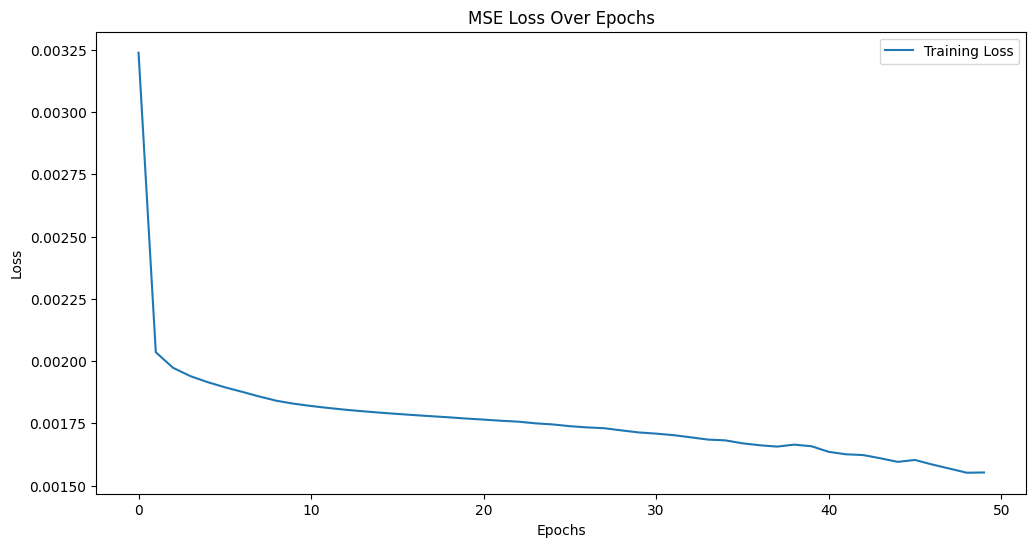

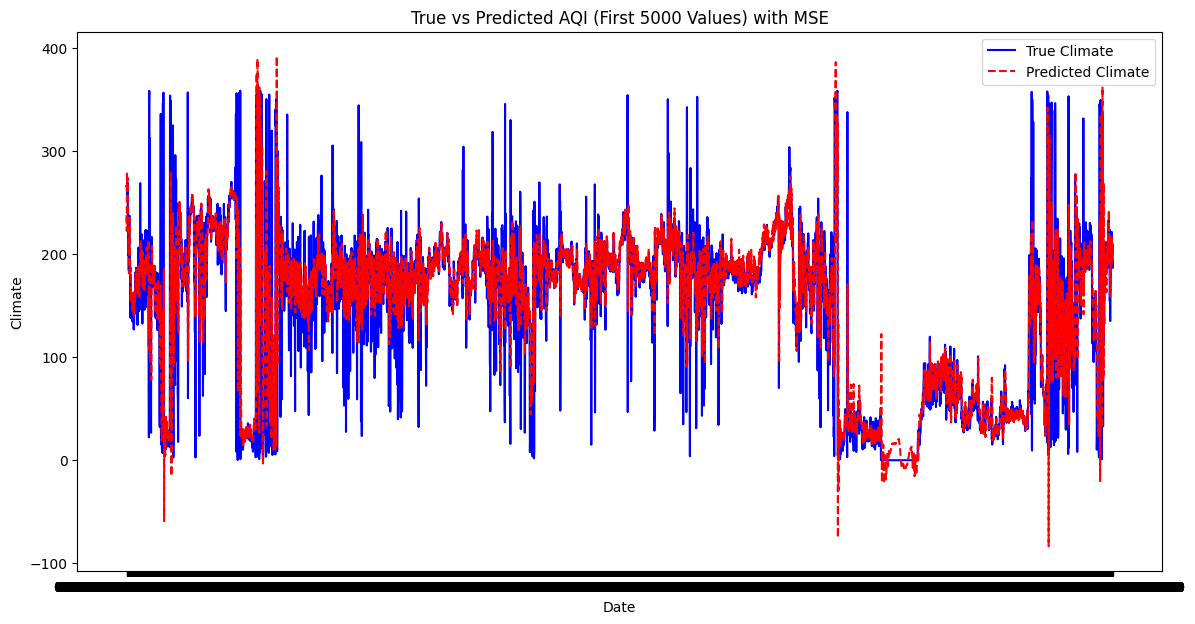

In [30]:
model = create_model(input_shape, output_dim)

# Train and plot with MSE loss
print("Training with Mean Squared Error Loss...")
[mae_mse,mse_mse,rmse_mse,r2_mse] = train_and_evaluate_with_plot(model, X_jena, y_jena, 'mse', "MSE", sequence_dates, scaler_jena, epochs=50)
model.save("model_mse_loss.h5")


In [34]:
# Compare Results

print("\nComparison of MAE for Loss Functions:")
print(f"The accuracy using Custom Loss - MAE: {mae_custom:.4f}")
print(f"The accuracy using MSE Loss - MAE: {mae_mse:.4f}")

print("\nComparison of MSE for Loss Functions:")
print(f"The accuracy using Custom Loss - MSE: {mse_custom:.4f}")
print(f"The accuracy using MSE Loss - MSE: {mse_mse:.4f}")

print("\nComparison of RMSE for Loss Functions:")
print(f"The accuracy using Custom Loss - RMSE: {rmse_custom:.4f}")
print(f"The accuracy using MSE Loss - RMSE: {rmse_mse:.4f}")

print("\nComparison of R2 for Loss Functions:")
print(f"The accuracy using Custom Loss - R2: {r2_custom:.4f}")
print(f"The accuracy using MSE Loss - R2: {r2_mse:.4f}")




Comparison of MAE for Loss Functions:
The accuracy using Custom Loss - MAE: 0.0111
The accuracy using MSE Loss - MAE: 0.0132

Comparison of MSE for Loss Functions:
The accuracy using Custom Loss - MSE: 0.0017
The accuracy using MSE Loss - MSE: 0.0017

Comparison of RMSE for Loss Functions:
The accuracy using Custom Loss - RMSE: 0.0417
The accuracy using MSE Loss - RMSE: 0.0416

Comparison of R2 for Loss Functions:
The accuracy using Custom Loss - R2: 0.9570
The accuracy using MSE Loss - R2: 0.9562
